In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import munkres
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
import math

In [38]:
#Sprawdzenie z nazwy, czy warstwa jest gęstwa czy konwolucyjna - uproszczenie implementacyjne
def is_dense(x):
    return True if str(x)[37:].split(' ')[0]=='Dense' else False
def is_conv2d(x):
    return True if str(x)[46:].split(' ')[0]=='Conv2D' else False

#Funkcja kosztu używana dla standardowej sieci neuronowej; dead_model - wzorzec sieci, undead_model - wytrenowana sieć
def kost(dead_model, undead_model):
    neue=None
    worse_numerator, better_numerator, denominator=0, 0, 0
        
    for ij, (x, y)  in enumerate(zip(dead_model.layers, undead_model.layers)):
        print(f'Processed layer: {ij}')
        if is_dense(x):
            bx=x.weights[1]
            by=y.weights[1]
            x=x.weights[0]
            y=y.weights[0]
                        
            ln=x.shape[1]
            
            if neue is not None:
                x=neue
            worse_part=tf.reduce_sum((x-y)*(x-y))+tf.reduce_sum((bx-by)*(bx-by))
            worse_numerator+=worse_part
            
            group_dead, group_undead=[], []
            cos_sim=tf.keras.losses.CosineSimilarity(-1)

            for i in range(ln):
                group_dead.append(tf.concat([x[:,i], [by[i]]], axis=0))
                group_undead.append(tf.concat([y[:,i], [by[i]]], axis=0))

            hungary=[]
            for i, d_el in enumerate(group_dead):
                hungary.append([])
                for j, u_el in enumerate(group_undead):
                    # Gdyby to faktycznie było cosine similarity, tu powinien być minus;
                    # Ale to nie jest cosine similarity, to jest -cosine similarity z tensorflowa jako f. kosztu
                    hungary[i].append(cos_sim(d_el, u_el).numpy())

            m = munkres.Munkres() # Metoda węgierska w O(n^3)
            indexes = m.compute(hungary)
            cols=[v for w, v in indexes]
            transformator_lefty=np.zeros(shape=(ln, ln), dtype='float32')
            transformator_righty=np.zeros(shape=(ln, ln), dtype='float32')
            for i, v in enumerate(cols):
                transformator_lefty[v,i]=1
                transformator_righty[i,v]=1

            eld=y@transformator_lefty
            post_eld=tf.einsum('j,jj->j', by, transformator_lefty)
            if (ij<len(dead_model.layers)-1):
                if ij<len(dead_model.layers)-1 and is_dense(dead_model.layers[ij+1]):
                    point=ij+1
                elif ij<len(dead_model.layers)-2 and is_dense(dead_model.layers[ij+2]):
                    point=ij+2
                elif ij<len(dead_model.layers)-3 and is_dense(dead_model.layers[ij+3]):
                    point=ij+3
                else:
                    point=None
                if point is not None:
                    neue=transformator_righty@undead_model.layers[point].weights[0]
                    
            better_part=tf.reduce_sum((x-eld)*(x-eld))+tf.reduce_sum((bx-post_eld)*(bx-post_eld))
            better_numerator+=better_part
            
            denominator_part=(x.shape[0]*x.shape[1])+bx.shape[0]
            denominator+=denominator_part
            #print (f'LOG normal:    {worse_part/denominator_part}')
            #print (f'LOG hungarian: {better_part/denominator_part}')
    #Zwracana jest para - funkcja kosztu to better_numerator/denominator, ta opisana w skrypcie (nie uwzględniająca permutacji)
    #To worse_numerator/denominator - w ostatecznym rozrachunku nigdzie niewykorzystana jako wyjście z tej funkcji
    return better_numerator/denominator, worse_numerator/denominator

#Funkcja kosztu używana dla konwolucyjnej sieci neuronowej; dead_model - wzorzec sieci, undead_model - wytrenowana sieć
def slaby_kost(dead_model, undead_model):
    worse_numerator, better_numerator, denominator=0, 0, 0
        
    for ij, (x, y)  in enumerate(zip(dead_model.layers, undead_model.layers)):
        print(f'Processed layer: {ij}')
        if is_dense(x) or is_conv2d(x):
            bx=x.weights[1]
            by=y.weights[1]
            x=x.weights[0]
            y=y.weights[0]
            ln=x.shape[1]
                
            worse_numerator+=tf.reduce_sum((x-y)*(x-y))+tf.reduce_sum((bx-by)*(bx-by))
            denominator+=(x.shape[0]*x.shape[1])+bx.shape[0]
            #print (f'LOG normal:    {(tf.reduce_sum((x-y)*(x-y))+tf.reduce_sum((bx-by)*(bx-by)))/(x.shape[0]*x.shape[1]+bx.shape[0])}')
    #Tu zwracana jest wartość funkcji kosztu jako zwykłe MSE wag - to samo, co 2. wartość na wyjściu funkcji kost()
    return worse_numerator/denominator, worse_numerator/denominator

In [39]:
# Funkcja zwracająca model sieci neuronowej - weights oznacza sieć z zainicjalizowanymi stałymi wartościami wagami, 
# Conv oznacza sieć konwolucyjną
def model_generator1(weights=None, dropout_rate=0.0, bnorm=False, momentum=0.99, conv=False, conv_weights=None):
    activations=["sigmoid", "sigmoid", "relu", "tanh", "sigmoid"]
    units=[50, 100, 100, 100, 5]
    
    # Wagi, którymi będzie inicjalizowana sieć są w init...
    if weights!=None:
        init, init2, init3=[], [], [] #Kolejno: W, bias, Conv
        for i in range(len(weights)):
            init.append(tf.constant_initializer(weights[i][0].numpy()))
            init2.append(tf.constant_initializer(weights[i][1].numpy()))
        if conv==True:
            for i in range(len(conv_weights)):
                init3.append(tf.constant_initializer(conv_weights[i][0].numpy()))
    # Tworzenie densów poprzecinanych dropoutami (domyślnie z rate=0 - tak, żeby nie miały wpływu na kalkulacje)
    lst=[]
    
    # Jeśli ma zostać stworzona sieć konwolucyjna, to na początku listy warstw dodawane są warstwy konwoluyjne/
    # max_pool i regularyzacja tak, jak zapisano w sprawku 
    if conv==True:
        for i in range(2):
            if weights!=None:
                lst.append(tf.keras.layers.Conv2D(filters=10, kernel_size=(2,2), padding='same', activation='relu', kernel_initializer=init3[i]))
            else:
                lst.append(tf.keras.layers.Conv2D(filters=10, kernel_size=(2,2), padding='same', activation='relu'))
            lst.append(tf.keras.layers.Dropout(dropout_rate))
            lst.append(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
            if bnorm==True:
                lst.append(tf.keras.layers.BatchNormalization(momentum=momentum))        
        lst.append(tf.keras.layers.Flatten())
        activations=["sigmoid", "sigmoid", "sigmoid"]
        units=[100, 100, 5]
    
    # Tworzenie "tylnej" części sieci neuronowej z listy. Warto zauważyć, że jeśli sieć to conv, aktywacje i unitsy
    # Są zmieniane względem tych podanych na początku funkcji
    v=0
    for u, act in zip(units, activations):
        if v>0 and bnorm==True:
            lst.append(tf.keras.layers.BatchNormalization(momentum=momentum)) #Bnorm
        if v>0:
            lst.append(tf.keras.layers.Dropout(dropout_rate)) #Dropout
        if weights!=None:
            lst.append(tf.keras.layers.Dense(units=u, activation=act, kernel_initializer=init[v], bias_initializer=init2[v])) #Przygotowana waga
        else:
            lst.append(tf.keras.layers.Dense(units=u, activation=act, bias_initializer=tf.random.normal)) # Nieprzygotowana waga
        v+=1
    
    return tf.keras.Sequential(lst)

In [46]:
# Generowanie x-a, treningowego lub testowego
def generate_system(inputs, instances, fun=tf.random.normal):
    return fun((instances, *inputs))

# Kalkulacja MSE pomiędzy dwoma wektorami
def testo(eval_set, ideal_y, neural):
    predicted_y=neural(eval_set)
    optim=tf.keras.losses.MeanSquaredError()
    return optim(predicted_y, ideal_y)

# Wykonanie jednego eksperymentu - sol_type to nazwa regularyzacji, weights to wagi, którymi zainicjalizowana
# Zostanie wzorcowa sieć neuronowa (pochodzącymi z prewzorcowej sieci neuronowej - która ma te same wagi, ale
# niekoniecznie strukturę; np. może mieć jakieś wartwy regularyzacji, które nie są dropoutami z dropout_rate=0)
def generate_all_models(sol_type, weights, training_x, test_x, weight_decay=None, batch_size=32, **kwargs):
    ideal = model_generator1(weights, **kwargs)
    training_y, test_y=ideal(training_x), ideal(test_x)
    epochs=3
    results={}
    
    if weight_decay is not None: # Optymalizatory są różne, jeśli testowane jest weight_decay (AdamW i SGDW)
        optimizers=[['sgdw', tf.keras.optimizers.SGD(weight_decay)], ['adamw', tfa.optimizers.AdamW(weight_decay)]]
    else:
        optimizers=[['sgd', tf.keras.optimizers.SGD()], ['adam', tf.keras.optimizers.Adam()], ['adamw', tfa.optimizers.AdamW(0.0001)]]
    
    for opt in optimizers:
        imperfect = model_generator1(**kwargs)
        imperfect.compile(optimizer=opt[1], loss='mse')
        imperfect.fit(training_x.numpy(), training_y.numpy(), epochs=epochs, batch_size=batch_size)
        results_train = testo(training_x, training_y, imperfect)
        results_test = testo(test_x, test_y, imperfect)
        print(f"Train MSE {opt[0]}: {results_train}")
        print(f"Test MSE {opt[0]}:  {results_test}")
        
        #Poniższe operacje służą dokumentowaniu: dla jakich argumentów uzyskano jakie rezultaty
        post_fact=[kwargs[v] for v in kwargs if v!='conv_weights']
        real_fact=[sol_type, opt[0], weight_decay, batch_size]
        real_fact.extend((post_fact))
        if 'conv' in kwargs and kwargs['conv']==True:
            results[tuple(real_fact)]=(results_train, results_test, slaby_kost(ideal, imperfect))
        else:
            results[tuple(real_fact)]=(results_train, results_test, kost(ideal, imperfect))
    return results

# Wykonanie jednego pełnego testu
def test_hiperparams(number_of_weights=1, conv=False):
    significations=[]
    for ij in range(number_of_weights): # Number of weights - liczba różnych testów (każdy różni się tylko wagami prewzorcowej sieci i wartościami na wejście sieci)
        train_instances_no, test_instances_no, inputs=50000, 10000, [10]
        if conv==True:
            train_instances_no, test_instances_no, inputs=20000, 5000, [10, 10, 3]
            
        ideal = model_generator1(conv=conv)
        training_x, test_x = generate_system(inputs, train_instances_no, tf.random.uniform), generate_system(inputs, test_instances_no, tf.random.uniform)
        training_y, test_y = ideal(training_x), ideal(test_x)
        
        # Transformacja wag prewzorcowej (już zainicjalizowanej wagami - powyżej ewaluacja y) sieci neuronowej
        # Do wygodnej postaci w kontekście dalszego parsowania
        weights=[]
        conv_weights=[]
        for x in ideal.layers:
            if is_conv2d(x):
                conv_weights.append(x.weights)
            if is_dense(x):
                weights.append(x.weights)
        signification={}
        #Testowanie wartości dropout_rate
        for i in range(0, 6):
            print(f'Dropout eval, rate {i/10}')
            signification={**signification, **generate_all_models('dropout', weights, training_x, test_x, dropout_rate=i/10, conv=conv, conv_weights=conv_weights)}
        #Testowanie wartości momentum i batch_size
        for i in range(2, 9, 2):
            for j in [0.1, 0.5, 0.9, 0.95, 0.99, 0.999]:
                print(f'Batch normalization, momentum {j}, batch_size {2**i}')
                signification={**signification, **generate_all_models('batch_norm', weights, training_x, test_x, batch_size=2**i, bnorm=True, momentum=j, conv=conv, conv_weights=conv_weights)}
        #Testowanie wartości weight_decay
        dissolution=[0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001]
        for i in dissolution:
            print(f'Weight_decay, rate {i}')
            signification={**signification, **generate_all_models('weight_decay', weights, training_x, test_x, weight_decay=i, conv=conv, conv_weights=conv_weights)}
        significations.append(signification)
    return significations

#res1=test_hiperparams(conv=False) # Uruchomienie testów dla 1. funckji kosztu, standardowa sieć neuronowa - około 1.5h
res2=test_hiperparams(conv=True) #Uruchomienie testów dla 2. funckji kosztu, sieć konwolucyjna - około 20 minut

Dropout eval, rate 0.0
Epoch 1/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0218
Epoch 2/3
625/625 [==============================] - 1s 2ms/step - loss: 1.2200e-04
Epoch 3/3
625/625 [==============================] - 1s 2ms/step - loss: 9.1176e-06
Train MSE sgd: 2.5222086605936056e-06
Test MSE sgd:  2.5151421141345054e-06
Processed layer: 0
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
Processed layer: 10
Processed layer: 11
Epoch 1/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0019
Epoch 2/3
625/625 [==============================] - 1s 2ms/step - loss: 5.9556e-07
Epoch 3/3
625/625 [==============================] - 1s 2ms/step - loss: 5.4113e-07
Train MSE adam: 5.98707970311807e-07
Test MSE adam:  5.942812890680216e-07
Processed layer: 0
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
Proce

Epoch 1/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0573
Epoch 2/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0167
Epoch 3/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0149
Train MSE sgd: 0.002369409892708063
Test MSE sgd:  0.0023702525068074465
Processed layer: 0
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
Processed layer: 10
Processed layer: 11
Epoch 1/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0081
Epoch 2/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0019
Epoch 3/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0013
Train MSE adam: 6.139800825621933e-05
Test MSE adam:  6.14003511145711e-05
Processed layer: 0
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed

5000/5000 [==============================] - 5s 1ms/step - loss: 0.0049
Epoch 2/3
5000/5000 [==============================] - 5s 1ms/step - loss: 5.3151e-05
Epoch 3/3
5000/5000 [==============================] - 5s 1ms/step - loss: 6.8827e-06
Train MSE adam: 2.4229891550930915e-06
Test MSE adam:  2.387600716247107e-06
Processed layer: 0
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
Processed layer: 10
Processed layer: 11
Processed layer: 12
Processed layer: 13
Processed layer: 14
Processed layer: 15
Epoch 1/3
5000/5000 [==============================] - 5s 1ms/step - loss: 0.0061
Epoch 2/3
5000/5000 [==============================] - 6s 1ms/step - loss: 1.1012e-05
Epoch 3/3
5000/5000 [==============================] - 5s 1ms/step - loss: 4.3065e-07
Train MSE adamw: 3.684312446239346e-07
Test MSE adamw:  3.7554679011009284e-07
Processed layer: 0
Processed layer: 

1250/1250 [==============================] - 2s 2ms/step - loss: 0.0289
Epoch 2/3
1250/1250 [==============================] - 2s 2ms/step - loss: 2.1321e-04
Epoch 3/3
1250/1250 [==============================] - 2s 2ms/step - loss: 4.1254e-05
Train MSE adamw: 1.0083156666951254e-05
Test MSE adamw:  9.475525075686164e-06
Processed layer: 0
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
Processed layer: 10
Processed layer: 11
Processed layer: 12
Processed layer: 13
Processed layer: 14
Processed layer: 15
Batch normalization, momentum 0.9, batch_size 16
Epoch 1/3
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1623
Epoch 2/3
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0575
Epoch 3/3
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0129
Train MSE sgd: 0.006548132281750441
Test MSE sgd:  0.006573202554136515


Epoch 1/3
313/313 [==============================] - 1s 4ms/step - loss: 0.1679
Epoch 2/3
313/313 [==============================] - 1s 4ms/step - loss: 0.1330
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 0.1008
Train MSE sgd: 0.10034750401973724
Test MSE sgd:  0.10149367153644562
Processed layer: 0
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
Processed layer: 10
Processed layer: 11
Processed layer: 12
Processed layer: 13
Processed layer: 14
Processed layer: 15
Epoch 1/3
313/313 [==============================] - 1s 4ms/step - loss: 0.0223
Epoch 2/3
313/313 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 6.3589e-04
Train MSE adam: 0.0006266529089771211
Test MSE adam:  0.0006477365386672318
Processed layer: 0
Processed layer: 1
Processed layer: 2
Pro

Epoch 1/3
313/313 [==============================] - 1s 4ms/step - loss: 0.0276
Epoch 2/3
313/313 [==============================] - 1s 4ms/step - loss: 0.0010
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 5.6980e-04
Train MSE adam: 0.00035545905120670795
Test MSE adam:  0.00036895310040563345
Processed layer: 0
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
Processed layer: 10
Processed layer: 11
Processed layer: 12
Processed layer: 13
Processed layer: 14
Processed layer: 15
Epoch 1/3
313/313 [==============================] - 1s 4ms/step - loss: 0.0136
Epoch 2/3
313/313 [==============================] - 1s 4ms/step - loss: 6.9861e-04
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 3.2551e-04
Train MSE adamw: 0.00013674047659151256
Test MSE adamw:  0.0001438553154002875
Processed layer: 0
Processed layer: 1
Pro

79/79 [==============================] - 1s 7ms/step - loss: 0.0483
Epoch 2/3
79/79 [==============================] - 1s 7ms/step - loss: 0.0044
Epoch 3/3
79/79 [==============================] - 1s 7ms/step - loss: 0.0010
Train MSE adamw: 0.0007224625442177057
Test MSE adamw:  0.0007640388212166727
Processed layer: 0
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
Processed layer: 10
Processed layer: 11
Processed layer: 12
Processed layer: 13
Processed layer: 14
Processed layer: 15
Batch normalization, momentum 0.95, batch_size 256
Epoch 1/3
79/79 [==============================] - 1s 7ms/step - loss: 0.1601
Epoch 2/3
79/79 [==============================] - 1s 7ms/step - loss: 0.1511
Epoch 3/3
79/79 [==============================] - 1s 7ms/step - loss: 0.1428
Train MSE sgd: 0.13777360320091248
Test MSE sgd:  0.13762860000133514
Processed layer: 0
Processed laye

625/625 [==============================] - 1s 2ms/step - loss: 0.0206
Train MSE adamw: 0.02053445391356945
Test MSE adamw:  0.02053419128060341
Processed layer: 0
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
Processed layer: 10
Processed layer: 11
Weight_decay, rate 0.01
Epoch 1/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0408
Epoch 2/3
625/625 [==============================] - 1s 2ms/step - loss: 1.6427e-04
Epoch 3/3
625/625 [==============================] - 1s 2ms/step - loss: 1.2991e-05
Train MSE sgdw: 3.854494480037829e-06
Test MSE sgdw:  3.843786998913856e-06
Processed layer: 0
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
Processed layer: 10
Processed layer: 11
Epoch 1/3
625/625 [=============================

In [43]:
# Parsowanie zwróconych danych do wygodnej postaci w kontekście dalszego przetwarzania
def parser(significations):
    all_results=[]
    for single in significations:
        results={}
        for x in single:
            title=x[0] # Nazwa tuningu
            subtitle=x[1] # Nazwa grada
            if (title=='weight_decay'):
                value=x[2]
            if (title=='dropout'):
                value=x[4]
            if (title=='batch_norm'):
                value=x[3], x[5]

            if title not in results:
                results[title]={}

            if subtitle in results[title]:
                results[title][subtitle][title].append(value)
                results[title][subtitle]['train_y'].append(single[x][0].numpy())
                results[title][subtitle]['test_y'].append(single[x][1].numpy())
                results[title][subtitle]['w'].append(single[x][2][1].numpy())
            else:
                results[title][subtitle]={}
                results[title][subtitle][title]=[value]
                results[title][subtitle]['train_y']=[single[x][0].numpy()]
                results[title][subtitle]['test_y']=[single[x][1].numpy()]
                results[title][subtitle]['w']=[single[x][2][1].numpy()]
        all_results.append(results)
    return all_results

#results1=parser(res1)
results2=parser(res2)

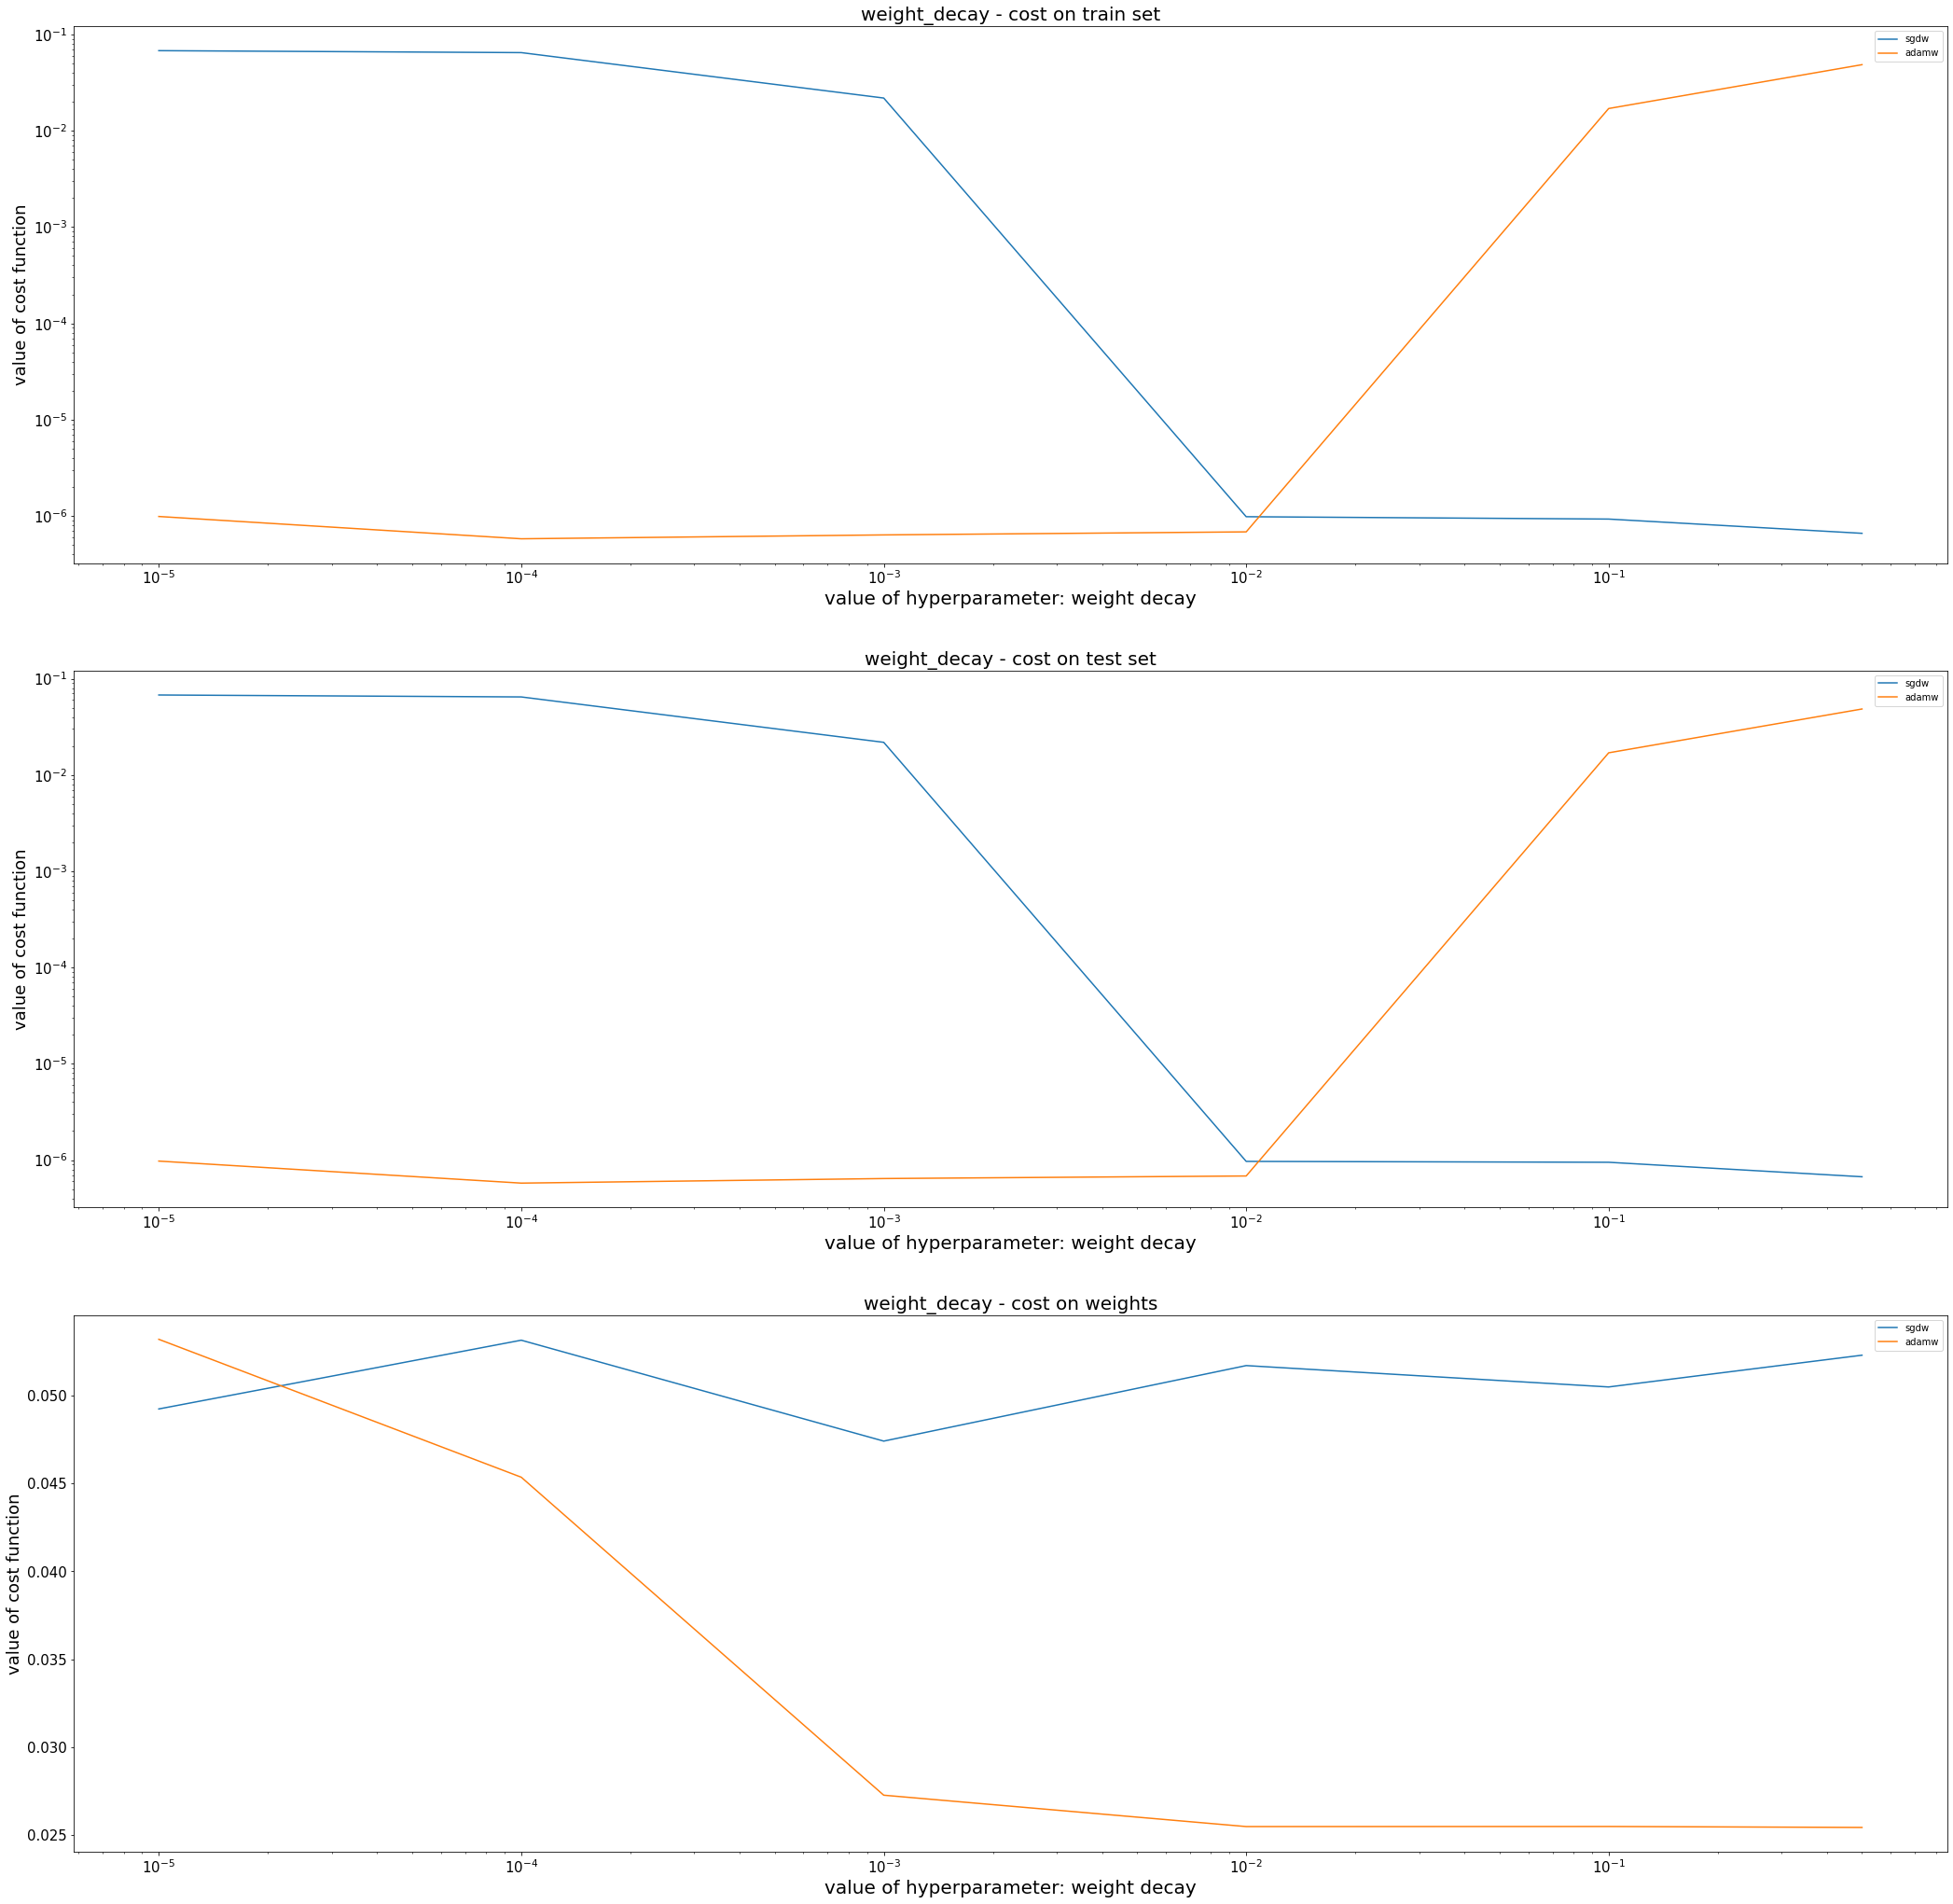

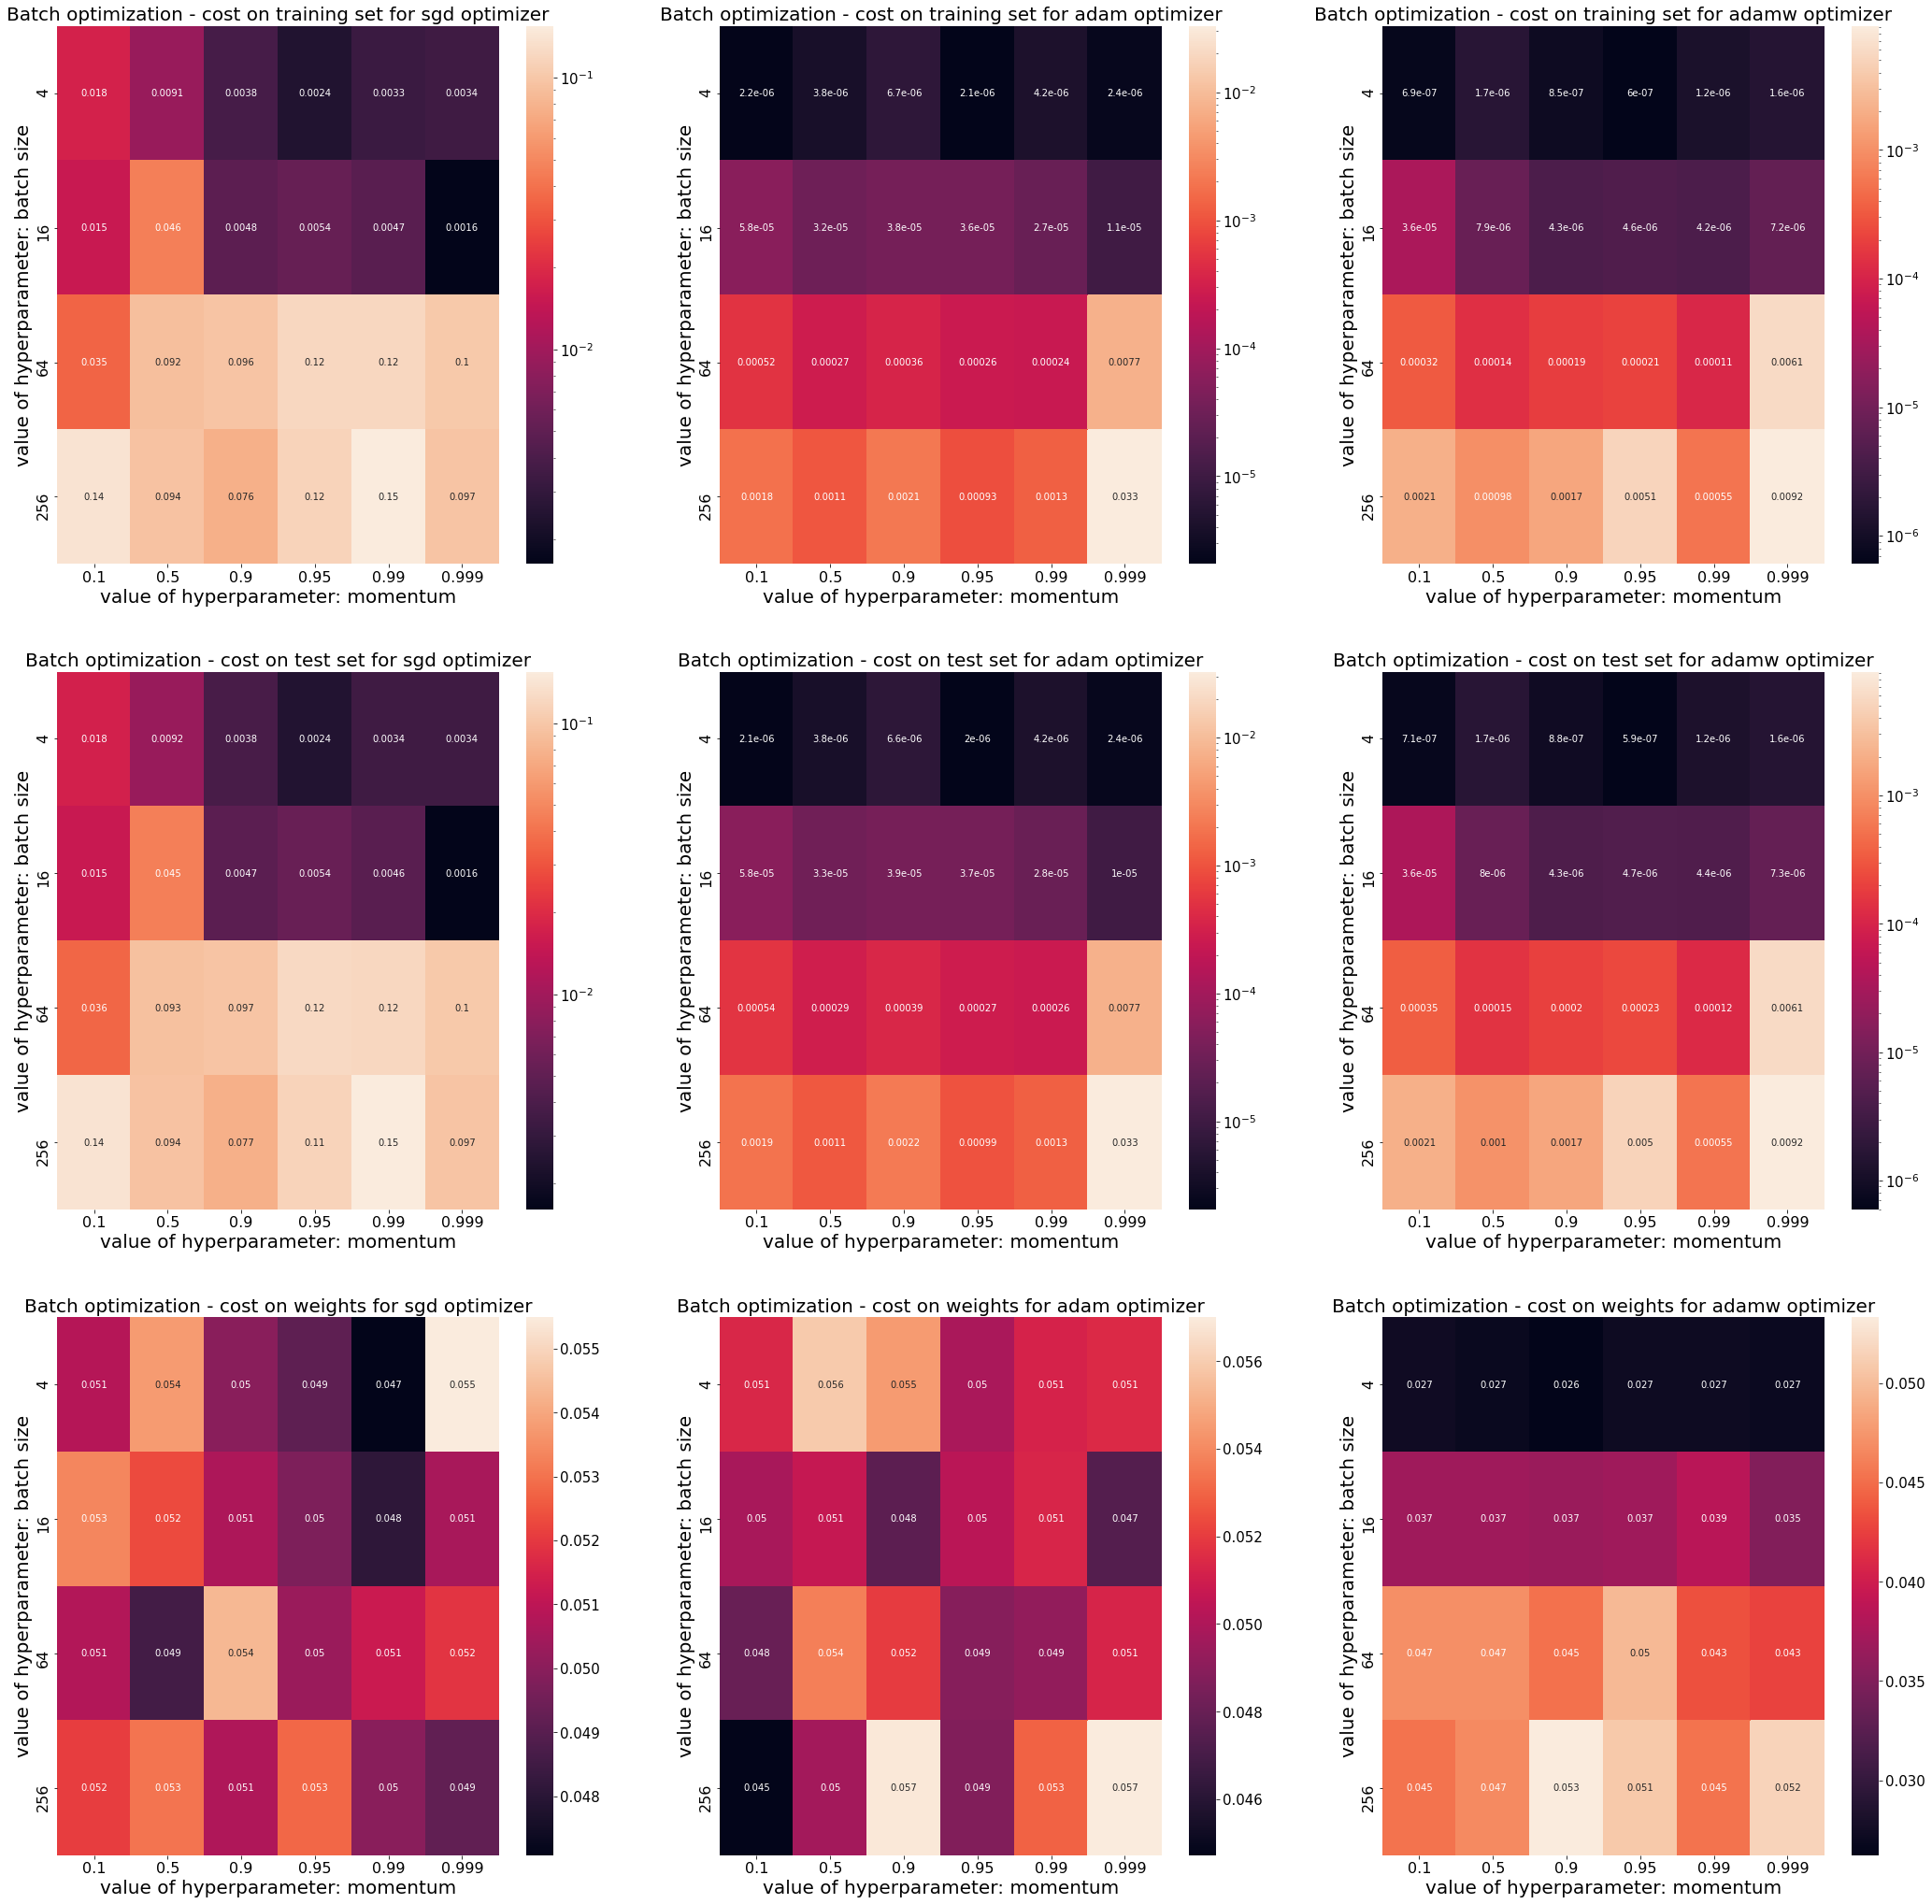

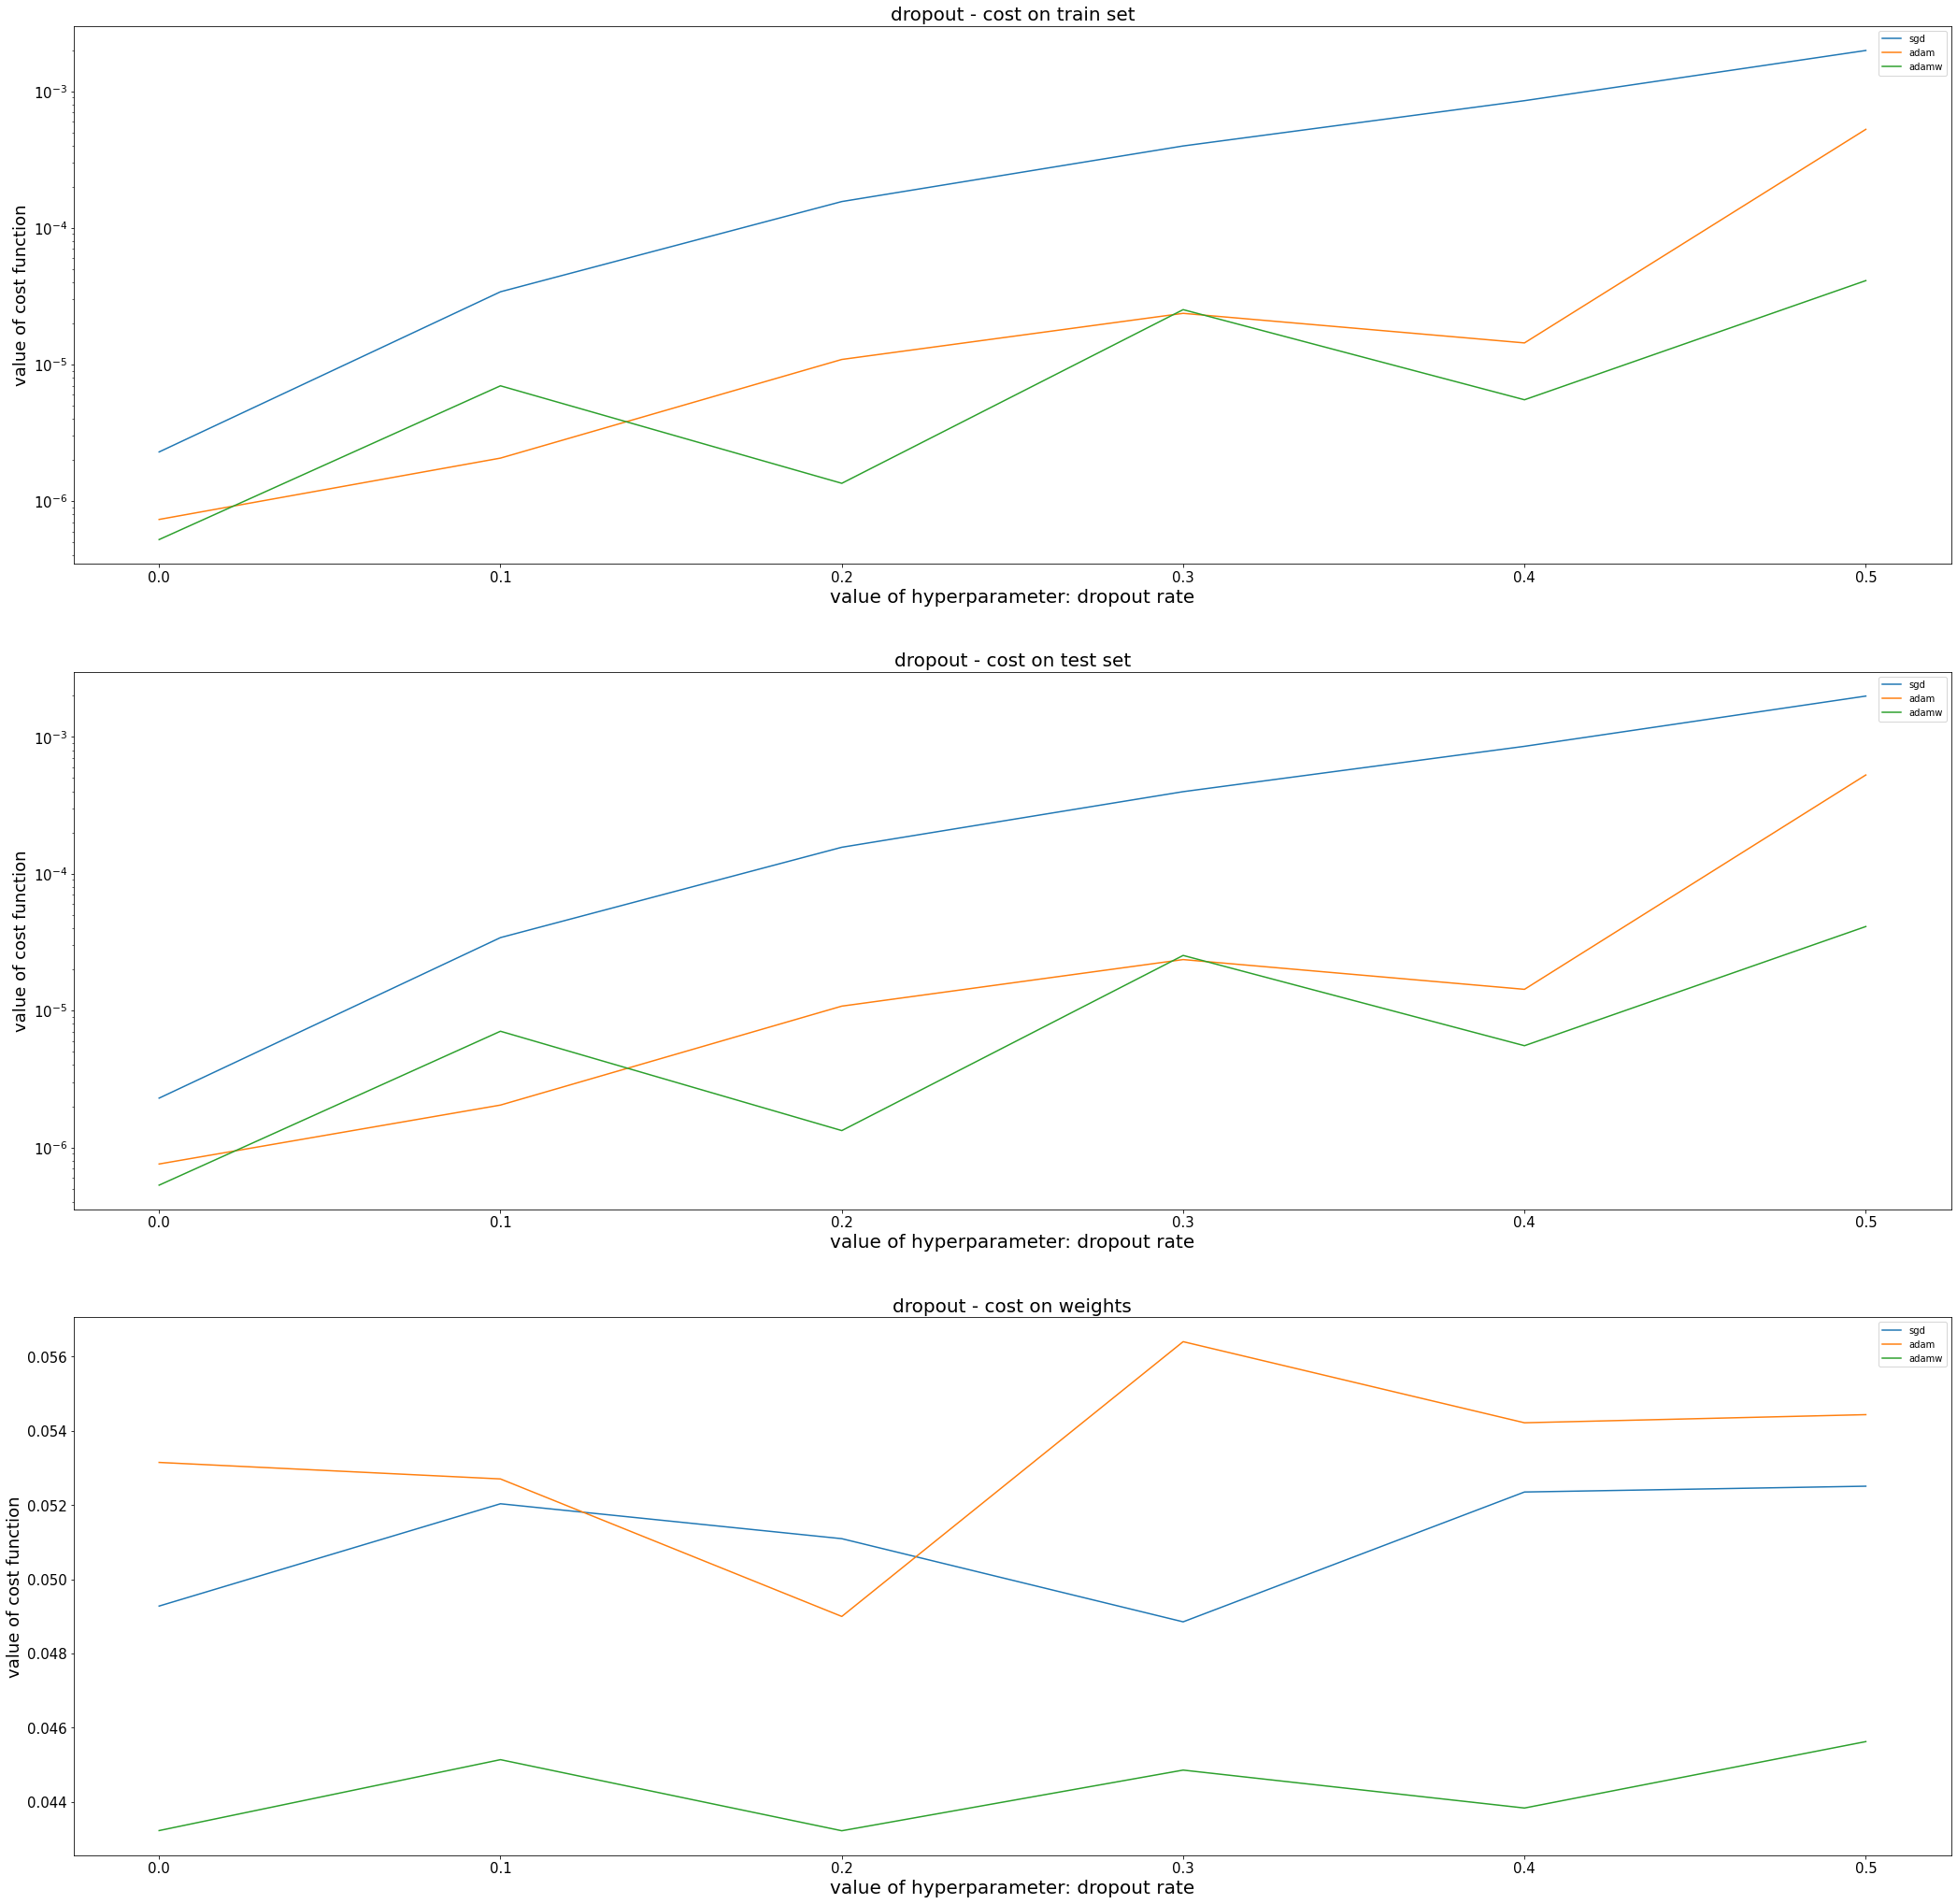

In [44]:
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
# Tworzenie wykresów w oparciu o sparsowane dane (results) i zapis do pliku oznaczonego jako 'Comparision_{y}_{name}.png', 
# Gdzie y to rodzaj testu (np. weight decay)
def one_last_time(results, name):
    size=20
    size_mini=16
    for y in ['weight_decay', 'batch_norm', 'dropout']:
        if (y!='batch_norm'):
            fig, ax=plt.subplots(3, 1, figsize=(36, 36))
            if y!='dropout':
                for i in range(3):
                    ax[i].set_xscale('log')
            for i in range(2):
                ax[i].set_yscale('log')

            for x in results[y]:
                ax[0].plot(results[y][x][y], results[y][x]['train_y'], label=x)
                ax[1].plot(results[y][x][y], results[y][x]['test_y'], label=x)
                ax[2].plot(results[y][x][y], results[y][x]['w'], label=x)
                ax[0].set_title(f'{y} - cost on train set', size=size)        
                ax[1].set_title(f'{y} - cost on test set', size=size)
                ax[2].set_title(f'{y} - cost on weights', size=size)

            for i in range(3):
                ax[i].legend()
                ax[i].set_xlabel(f'value of hyperparameter: {"weight decay" if y=="weight_decay" else "dropout rate"}', size=size)
                ax[i].set_ylabel('value of cost function', size=18)

        else:
            fig, ax=plt.subplots(3, 3, figsize=(36, 36))
            for ij, x in enumerate(results[y]):
                dct1, dct2={}, {}
                data=results[y][x][y]
                num=0
                for f1, f2 in data:
                    if f1 not in dct1:
                        dct1[f1]=num
                        num+=1
                num=0
                for f1, f2 in data:
                    if f2 not in dct2:
                        dct2[f2]=num
                        num+=1
                c_train_y=np.zeros((len(dct1), len(dct2)), dtype='float32')
                c_test_y=np.zeros((len(dct1), len(dct2)), dtype='float32')
                c_w=np.zeros((len(dct1), len(dct2)), dtype='float32')
                for f1, f2 in data:
                    c_train_y[dct1[f1],dct2[f2]]=[w for w, key in zip(results[y][x]['train_y'], results[y][x][y]) if key==(f1, f2)][0]
                    c_test_y[dct1[f1],dct2[f2]]=[w for w, key in zip(results[y][x]['test_y'], results[y][x][y]) if key==(f1, f2)][0]
                    c_w[dct1[f1],dct2[f2]]=[w for w, key in zip(results[y][x]['w'], results[y][x][y]) if key==(f1, f2)][0]

                sns.heatmap(c_train_y, ax=ax[0][ij], norm=matplotlib.colors.LogNorm(), annot=True)
                sns.heatmap(c_test_y, ax=ax[1][ij], norm=matplotlib.colors.LogNorm(), annot=True)
                sns.heatmap(c_w, ax=ax[2][ij], annot=True)
                ax[0][ij].set_title(f'Batch optimization - cost on training set for {x} optimizer', size=size)
                ax[1][ij].set_title(f'Batch optimization - cost on test set for {x} optimizer', size=size)
                ax[2][ij].set_title(f'Batch optimization - cost on weights for {x} optimizer', size=size)
            for i in range(3):
                for j in range(3):                       
                    ax[i][j].set_ylabel('value of hyperparameter: batch size', size=size)
                    ax[i][j].set_xlabel('value of hyperparameter: momentum', size=size)
                    ax[i][j].set_yticklabels([z for z in dct1], size=size_mini)
                    ax[i][j].set_xticklabels([z for z in dct2], size=size_mini)


        plt.show()
        fig.savefig(f'Comparision_{y}_{name}.png')

#enum=1
#for i, x in enumerate(results1):
#    one_last_time(x, f'ann_{enum+i}')
enum2=3
for i, x in enumerate(results2):
    one_last_time(x, f'conv_{enum2+i}')